In [1]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import json

In [2]:
face_landmarks = ['left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']

images_dir = "img"

In [3]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop(['Image','left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y'], axis=1)
    keypoint_features = []
    for idx, features in keypoint_data.iterrows():
        keypoint_features.append(features)
    keypoint_features = np.asarray(keypoint_features)
    return keypoint_features

def plot_sample(image, keypoint1, keypoint2):
    fig, axis = plt.subplots()
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint1[0::2], keypoint1[1::2], marker='x', s=20)
    axis.scatter(keypoint2[0::2], keypoint2[1::2], marker='o', s=20)
    
def save_files_to_upload(fname, image):
    image = image.reshape(96,96)
    plt.imsave(fname, image, cmap='gray')

def detect_face_landmarks(images):
    tvr_landmarks = []
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    
    for image in images:
        image_landmarks = []
        image_cv = np.squeeze((image * 255).astype(np.uint8), axis=2)
        gray = image_cv

        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)

            for n in [42, 45, 39, 36, 22, 26, 21, 17, 33, 54, 48, 51, 57]:
                image_landmarks.append(landmarks.part(n).x)
                image_landmarks.append(landmarks.part(n).y)
            tvr_landmarks.append(image_landmarks)
        if len(faces) == 0:
            tvr_landmarks.append([0] * 26)

    return np.asarray(tvr_landmarks)

def save_ann(fname, keypoints):
    class_titles = ['left_eye_inner_corner',
    'left_eye_outer_corner',
    'right_eye_inner_corner',
    'right_eye_outer_corner',
    'left_eyebrow_inner_end',
    'left_eyebrow_outer_end',
    'right_eyebrow_inner_end',
    'right_eyebrow_outer_end',
    'nose_tip',
    'mouth_left_corner',
    'mouth_right_corner',
    'mouth_center_top_lip',
    'mouth_center_bottom_lip']
    
    ann = {}
    ann["description"] = ""
    ann["tags"] = []
    ann["size"] = {
        "height": 96,
        "width": 96
    }
    ann["objects"] = []
    
    for i in range(len(class_titles)):
        new_obj = {
            "description": "",
            "geometryType": "point",
            "tags": []
        }
        new_obj["classTitle"] = class_titles[i]
        new_obj["points"] = {}
        new_obj["points"]["interior"] = []
        new_obj["points"]["exterior"] = [int(keypoints[2*i]), int(keypoints[2*i-1])]

        ann["objects"].append(new_obj)
        
    with open(fname + '.json', 'w', encoding='utf8') as f:
        json.dump(ann, f)
    

## 1. Базовая работа с python/numpy


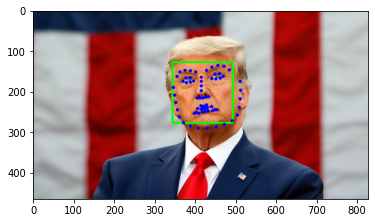

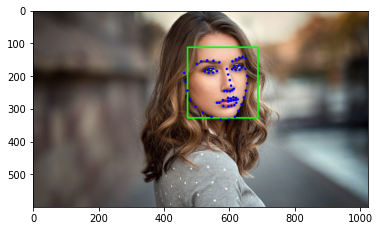

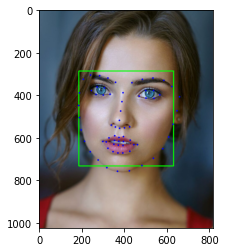

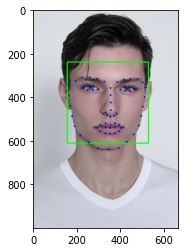

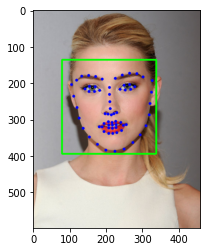

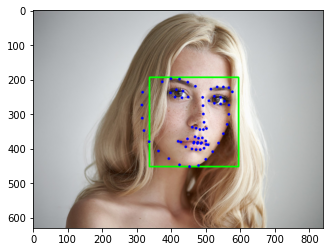

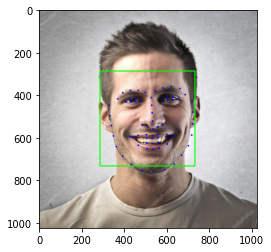

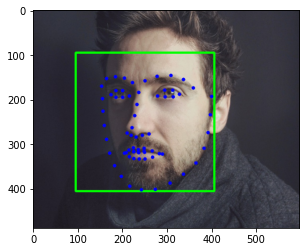

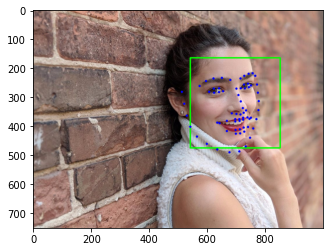

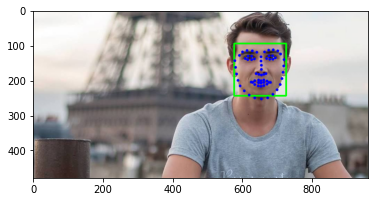

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

for path, subdirs, files in os.walk(images_dir):
    for fname in files:
        image = cv2.imread(path+"/"+fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        faces = detector(gray)
        for face in faces:
            x1 = face.left()
            y1 = face.top()
            x2 = face.right()
            y2 = face.bottom()
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)

            landmarks = predictor(gray, face)

            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                cv2.circle(image, (x, y), 4, (255, 0, 0), -1)
                
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## 2. Оценка метрик и валидация моделей

In [5]:
train_file = pd.read_csv('./training.csv')
train_file = train_file.fillna(0)

train_images = load_images(train_file)
train_keypoints = load_keypoints(train_file)

In [6]:
tvr_keypoints = detect_face_landmarks(train_images)

In [7]:
df_tvr = pd.DataFrame(tvr_keypoints, columns=face_landmarks)
df_diff_keypoints = pd.DataFrame(abs(tvr_keypoints-train_keypoints), columns=face_landmarks)

In [8]:
df_diff_keypoints.head()

,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,1.582075,0.352577,0.130346,0.030003,0.643429,0.610598,0.452872,0.389402,3.953263,3.033648,...,0.420571,5.933197,2.195308,1.029835,0.385504,0.611008,0.687398,2.064541,0.130707,1.485774
1,2.856170,0.725651,0.722723,1.187166,0.965277,0.638468,1.472511,1.144443,0.987404,3.275949,...,2.206298,6.339064,0.421447,0.352000,0.122383,1.047660,0.684596,0.733447,0.467915,1.480170
2,1.412000,0.320968,0.984421,1.320968,0.321895,0.320968,0.023579,0.603221,1.742526,0.570947,...,0.557263,6.461053,0.822947,0.014316,1.273684,0.268000,0.274947,0.191789,0.274947,0.340632
3,1.003339,0.127179,0.314713,1.380967,1.381357,0.245885,0.307270,0.007903,2.433809,0.929864,...,1.885078,7.833461,2.598887,0.296278,0.245496,0.195478,0.696835,0.091687,0.438817,0.731617
4,1.565890,0.621261,0.515926,0.884466,0.017620,0.094852,0.506110,1.305237,6.249571,1.672177,...,0.700466,2.110479,0.328589,0.476761,0.191755,2.002699,0.037252,2.292613,0.772859,3.871166


### Точность позиционирования

In [9]:
df_diff_keypoints['avg'] = df_diff_keypoints.mean(axis=1)

Среднее отклонение для каждой точки.
Наиболее точное позиционирование у nose_tip_x, mouth_center_bottom_lip_x и nose_tip_y.
Наименее точное - у left_eyebrow_outer_end_x, mouth_right_corner_y, left_eye_outer_corner_x.

In [10]:
df_diff_keypoints.mean()

left_eye_inner_corner_x      36.718134
left_eye_inner_corner_y      24.307078
left_eye_outer_corner_x      45.487210
left_eye_outer_corner_y      23.786041
right_eye_inner_corner_x     23.506676
right_eye_inner_corner_y     24.505937
right_eye_outer_corner_x     14.731009
right_eye_outer_corner_y     24.168261
left_eyebrow_inner_end_x     34.522507
left_eyebrow_inner_end_y     18.699369
left_eyebrow_outer_end_x     51.058961
left_eyebrow_outer_end_y     19.935668
right_eyebrow_inner_end_x    25.967815
right_eyebrow_inner_end_y    18.867099
right_eyebrow_outer_end_x    10.014567
right_eyebrow_outer_end_y    20.457984
nose_tip_x                    4.668719
nose_tip_y                    7.556877
mouth_left_corner_x          40.820830
mouth_left_corner_y          46.363834
mouth_right_corner_x         20.029581
mouth_right_corner_y         46.586377
mouth_center_top_lip_x       30.225334
mouth_center_top_lip_y       45.632494
mouth_center_bottom_lip_x     4.758192
mouth_center_bottom_lip_y

Среднее значение отклонения позиционирования для всех точек.

In [11]:
df_diff_keypoints['avg'].mean()

25.87432374946033

### Точность детектирования

In [12]:
detection_precision = df_tvr.apply( lambda s : 100 - s.value_counts().get(key=0,default=0) / 7049 * 100, axis=0)

Нормализованное количество распознанных точек ко всему количеству точек.
Для 511 изображений моделью не была распознана ни одна из точек - подавляющая точность для точек - 92.75%.
Наименьшая точность - right_eyebrow_outer_end_x.

In [13]:
detection_precision

left_eye_inner_corner_x      92.750745
left_eye_inner_corner_y      92.750745
left_eye_outer_corner_x      92.750745
left_eye_outer_corner_y      92.750745
right_eye_inner_corner_x     92.750745
right_eye_inner_corner_y     92.750745
right_eye_outer_corner_x     92.736558
right_eye_outer_corner_y     92.750745
left_eyebrow_inner_end_x     92.750745
left_eyebrow_inner_end_y     92.750745
left_eyebrow_outer_end_x     92.750745
left_eyebrow_outer_end_y     92.750745
right_eyebrow_inner_end_x    92.750745
right_eyebrow_inner_end_y    92.750745
right_eyebrow_outer_end_x    92.708186
right_eyebrow_outer_end_y    92.750745
nose_tip_x                   92.750745
nose_tip_y                   92.750745
mouth_left_corner_x          92.750745
mouth_left_corner_y          92.750745
mouth_right_corner_x         92.750745
mouth_right_corner_y         92.750745
mouth_center_top_lip_x       92.750745
mouth_center_top_lip_y       92.750745
mouth_center_bottom_lip_x    92.750745
mouth_center_bottom_lip_y

Средняя точность детектирования для всех точек

In [14]:
detection_precision.mean()

92.74856226196844

### 5 изображений с наибольшим качеством детектирования

In [15]:
df_diff_keypoints.nsmallest(5,'avg')

,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,avg
1566,1.566142,0.146013,2.207071,0.352877,0.937652,0.144413,0.202168,1.023794,2.406865,0.037832,...,5.184929,0.102865,0.048310,0.051819,0.119897,0.254606,0.622606,0.922013,0.057239,0.759535
449,1.293693,0.461634,0.598528,0.485546,0.183706,0.591185,1.656049,0.538366,1.345914,1.852427,...,3.615509,0.336098,0.139779,0.553325,0.349988,0.292025,0.718773,0.971239,0.757791,0.794353
1354,0.047842,0.075010,2.722535,1.233822,2.046099,0.093228,1.301545,0.224396,0.178376,1.504317,...,2.698455,0.104396,0.585030,0.328079,0.239129,0.477149,0.089743,0.318337,1.163327,0.838282
508,2.173126,0.258731,0.009102,0.231071,0.107162,1.057035,0.748216,1.029432,0.007281,1.808441,...,4.133844,0.825054,0.225677,0.003593,0.004024,0.616814,0.316072,0.102898,0.838180,0.844471
247,1.788651,0.699107,0.013395,0.051460,0.665488,0.049191,1.361860,0.051460,0.550512,2.817805,...,3.746605,1.777302,0.024930,0.595349,0.024930,0.563907,0.768744,0.813395,0.539907,0.845040


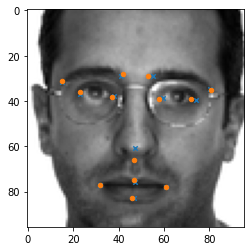

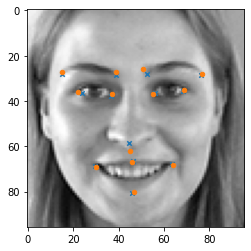

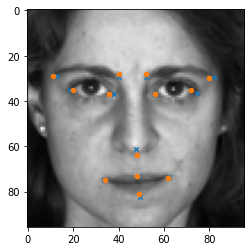

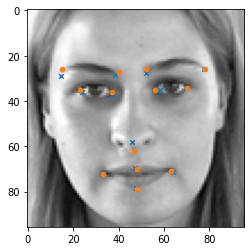

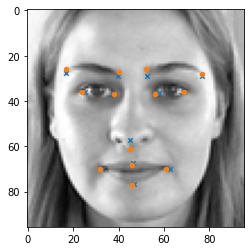

In [16]:
for idx in df_diff_keypoints.nsmallest(5,'avg').index:
    plot_sample(train_images[idx], train_keypoints[idx], tvr_keypoints[idx])

### 5 изображений с наименьш качеством детектирования

Модель opencv 68-point вообще не смогла определить точки на этих изображениях.

In [17]:
df_diff_keypoints.nlargest(5,'avg')

,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,avg
1523,66.324267,45.257244,82.221511,45.065956,40.467200,44.108089,23.803733,42.384356,59.045689,38.745244,...,64.793956,67.473422,87.203200,33.763200,87.586489,51.767467,85.287822,51.576178,91.800178,54.405812
1927,65.847820,37.992492,85.837756,36.378626,39.439098,38.579353,20.989671,38.359280,55.248980,31.106737,...,75.992731,84.767123,82.642438,37.129438,83.246296,57.291585,90.928711,58.968968,94.719597,53.361644
1379,61.068620,45.181070,73.621408,44.848000,47.293746,44.181408,34.629859,42.292958,60.068732,40.293408,...,61.066592,63.068169,72.064225,43.183549,71.842028,52.626028,71.175437,52.959099,76.174423,53.083562
1864,56.125774,40.066589,73.833931,36.100815,37.686819,41.856869,20.786386,41.846962,49.020154,34.913513,...,71.320257,73.613284,75.196106,41.750859,80.572008,57.619409,82.704789,57.619409,83.555407,51.548090
2226,62.847302,37.693710,78.595918,37.048700,42.251272,36.488230,28.582164,35.781046,58.692759,23.759016,...,67.842661,65.413792,94.673637,38.273864,91.676467,49.216979,90.985631,49.235989,93.211741,51.528433


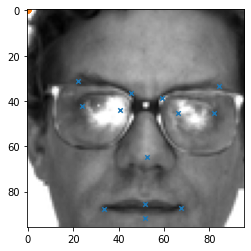

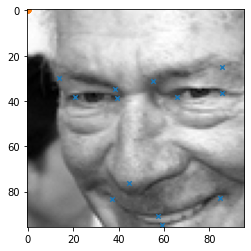

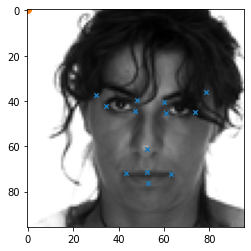

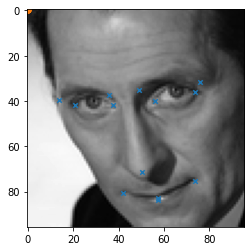

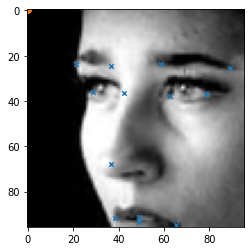

In [18]:
for idx in df_diff_keypoints.nlargest(5,'avg').index:
    plot_sample(train_images[idx], train_keypoints[idx], tvr_keypoints[idx])

### Сохранение изображений и разметки для загрузки в Supervisely

In [20]:
least_acc_idx = df_diff_keypoints.nlargest(5,'avg').index
for i in range(len(least_acc_idx)):
    save_ann("dataset_sly/dataset/ann/"+str(i+1), tvr_keypoints[least_acc_idx[i]])
    save_files_to_upload("dataset_sly/dataset/img/"+str(i+1)+".jpg", train_images[least_acc_idx[i]])

## 3. Работа с инструментами разметки

In [21]:
import supervisely_lib as sly
import json
from tqdm import tqdm

In [22]:
project_directory = "dataset_sly"

team_name = "dardiv"
workspace_name = "Onecell"
project_name = "face_landmarks"

address = "https://app.supervise.ly/"
token = "g3gXv7Gh4QAQrGBsDKJ1maF0WDhWTuctJksX96KsOJH8dGwdBd3YOwfrX9tZulM5ezscb5tqZGCjiz8BsvVeikcvLQQ7RSQhAmbyl86gE2Fm9Q6C3FrosDdiENsYvfq0"

In [23]:
api = sly.Api(address, token)

In [24]:

team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))

Team: id=52746, name=dardiv
Workspace: id=61363, name=Onecell


In [25]:
project_fs = sly.Project(project_directory, sly.OpenMode.READ)

In [26]:
if api.project.exists(workspace.id, project_name):
    project_name = api.project.get_free_name(workspace.id, project_name)

In [27]:
project = api.project.create(workspace.id, project_name)
api.project.update_meta(project.id, project_fs.meta.to_json())
print("Project: id={}, name={}".format(project.id, project.name))

Project: id=157335, name=face_landmarks_004


In [28]:
for dataset_fs in project_fs:
    dataset = api.dataset.create(project.id, dataset_fs.name)
    
    names, img_paths, ann_paths = [], [], []
    for item_name in dataset_fs:
        img_path, ann_path = dataset_fs.get_item_paths(item_name)
        names.append(item_name)
        img_paths.append(img_path)
        ann_paths.append(ann_path)
    
    print("Dataset: {}. Will upload {} images with annotations".format(dataset.name, len(img_paths)), flush=True)
    with tqdm(total=len(names), desc="Upload images") as progress_bar:
        img_infos = api.image.upload_paths(dataset.id, names, img_paths, progress_bar.update)
    
    image_ids = [img_info.id for img_info in img_infos]
    with tqdm(total=len(names), desc="Upload annotations") as progress_bar:
        api.annotation.upload_paths(image_ids, ann_paths, progress_bar.update)  

Dataset: dataset. Will upload 5 images with annotations


Upload annotations:   0%|                                                                        | 0/5 [00:00<?, ?it/s]


HTTPError: 400 Client Error: Bad Request for url: https://app.supervise.ly/public/api/v3/annotations.bulk.add ({"error":"Invalid annotations","details":[{"index":0,"errors":[{"index":0,"message":"object of type 'int' has no len()"},{"index":1,"message":"object of type 'int' has no len()"},{"index":2,"message":"object of type 'int' has no len()"},{"index":3,"message":"object of type 'int' has no len()"},{"index":4,"message":"object of type 'int' has no len()"},{"index":5,"message":"object of type 'int' has no len()"},{"index":6,"message":"object of type 'int' has no len()"},{"index":7,"message":"object of type 'int' has no len()"},{"index":8,"message":"object of type 'int' has no len()"},{"index":9,"message":"object of type 'int' has no len()"},{"index":10,"message":"object of type 'int' has no len()"},{"index":11,"message":"object of type 'int' has no len()"},{"index":12,"message":"object of type 'int' has no len()"}],"imageId":223480354,"imageName":"1.jpg"},{"index":1,"errors":[{"index":0,"message":"object of type 'int' has no len()"},{"index":1,"message":"object of type 'int' has no len()"},{"index":2,"message":"object of type 'int' has no len()"},{"index":3,"message":"object of type 'int' has no len()"},{"index":4,"message":"object of type 'int' has no len()"},{"index":5,"message":"object of type 'int' has no len()"},{"index":6,"message":"object of type 'int' has no len()"},{"index":7,"message":"object of type 'int' has no len()"},{"index":8,"message":"object of type 'int' has no len()"},{"index":9,"message":"object of type 'int' has no len()"},{"index":10,"message":"object of type 'int' has no len()"},{"index":11,"message":"object of type 'int' has no len()"},{"index":12,"message":"object of type 'int' has no len()"}],"imageId":223480355,"imageName":"2.jpg"},{"index":2,"errors":[{"index":0,"message":"object of type 'int' has no len()"},{"index":1,"message":"object of type 'int' has no len()"},{"index":2,"message":"object of type 'int' has no len()"},{"index":3,"message":"object of type 'int' has no len()"},{"index":4,"message":"object of type 'int' has no len()"},{"index":5,"message":"object of type 'int' has no len()"},{"index":6,"message":"object of type 'int' has no len()"},{"index":7,"message":"object of type 'int' has no len()"},{"index":8,"message":"object of type 'int' has no len()"},{"index":9,"message":"object of type 'int' has no len()"},{"index":10,"message":"object of type 'int' has no len()"},{"index":11,"message":"object of type 'int' has no len()"},{"index":12,"message":"object of type 'int' has no len()"}],"imageId":223480356,"imageName":"3.jpg"},{"index":3,"errors":[{"index":0,"message":"object of type 'int' has no len()"},{"index":1,"message":"object of type 'int' has no len()"},{"index":2,"message":"object of type 'int' has no len()"},{"index":3,"message":"object of type 'int' has no len()"},{"index":4,"message":"object of type 'int' has no len()"},{"index":5,"message":"object of type 'int' has no len()"},{"index":6,"message":"object of type 'int' has no len()"},{"index":7,"message":"object of type 'int' has no len()"},{"index":8,"message":"object of type 'int' has no len()"},{"index":9,"message":"object of type 'int' has no len()"},{"index":10,"message":"object of type 'int' has no len()"},{"index":11,"message":"object of type 'int' has no len()"},{"index":12,"message":"object of type 'int' has no len()"}],"imageId":223480357,"imageName":"4.jpg"},{"index":4,"errors":[{"index":0,"message":"object of type 'int' has no len()"},{"index":1,"message":"object of type 'int' has no len()"},{"index":2,"message":"object of type 'int' has no len()"},{"index":3,"message":"object of type 'int' has no len()"},{"index":4,"message":"object of type 'int' has no len()"},{"index":5,"message":"object of type 'int' has no len()"},{"index":6,"message":"object of type 'int' has no len()"},{"index":7,"message":"object of type 'int' has no len()"},{"index":8,"message":"object of type 'int' has no len()"},{"index":9,"message":"object of type 'int' has no len()"},{"index":10,"message":"object of type 'int' has no len()"},{"index":11,"message":"object of type 'int' has no len()"},{"index":12,"message":"object of type 'int' has no len()"}],"imageId":223480358,"imageName":"5.jpg"}]})

### Интерфейс сервиса

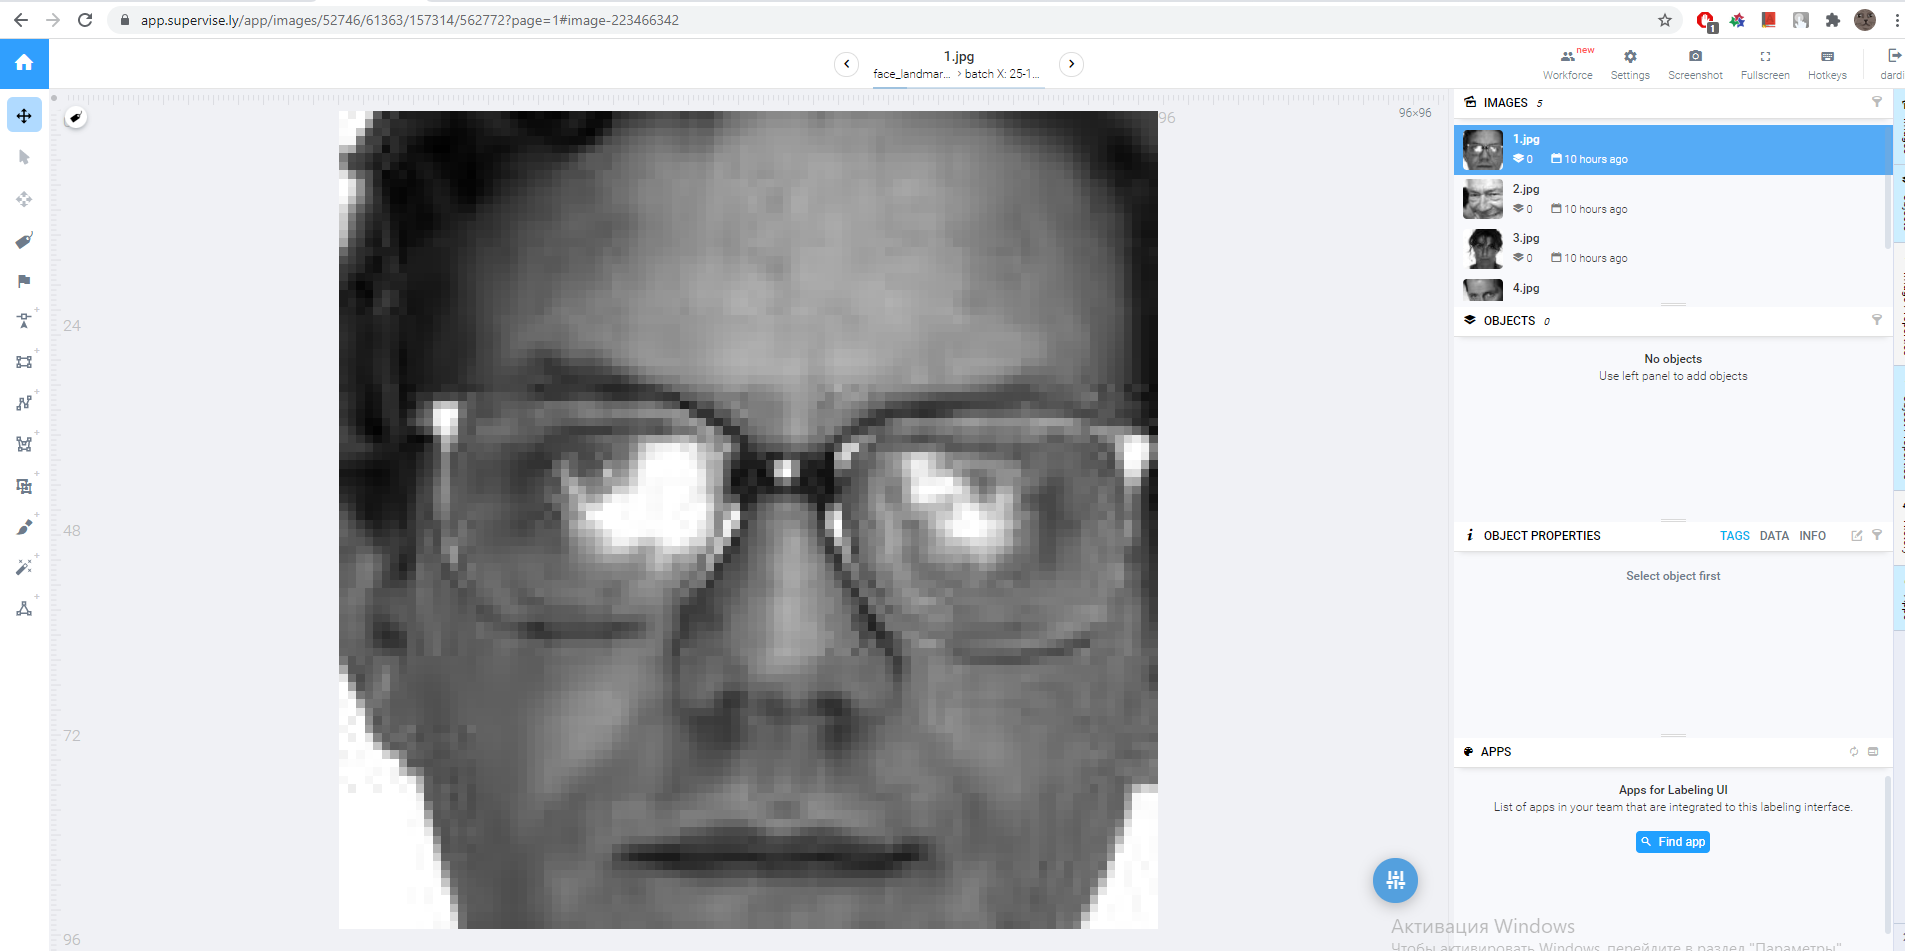

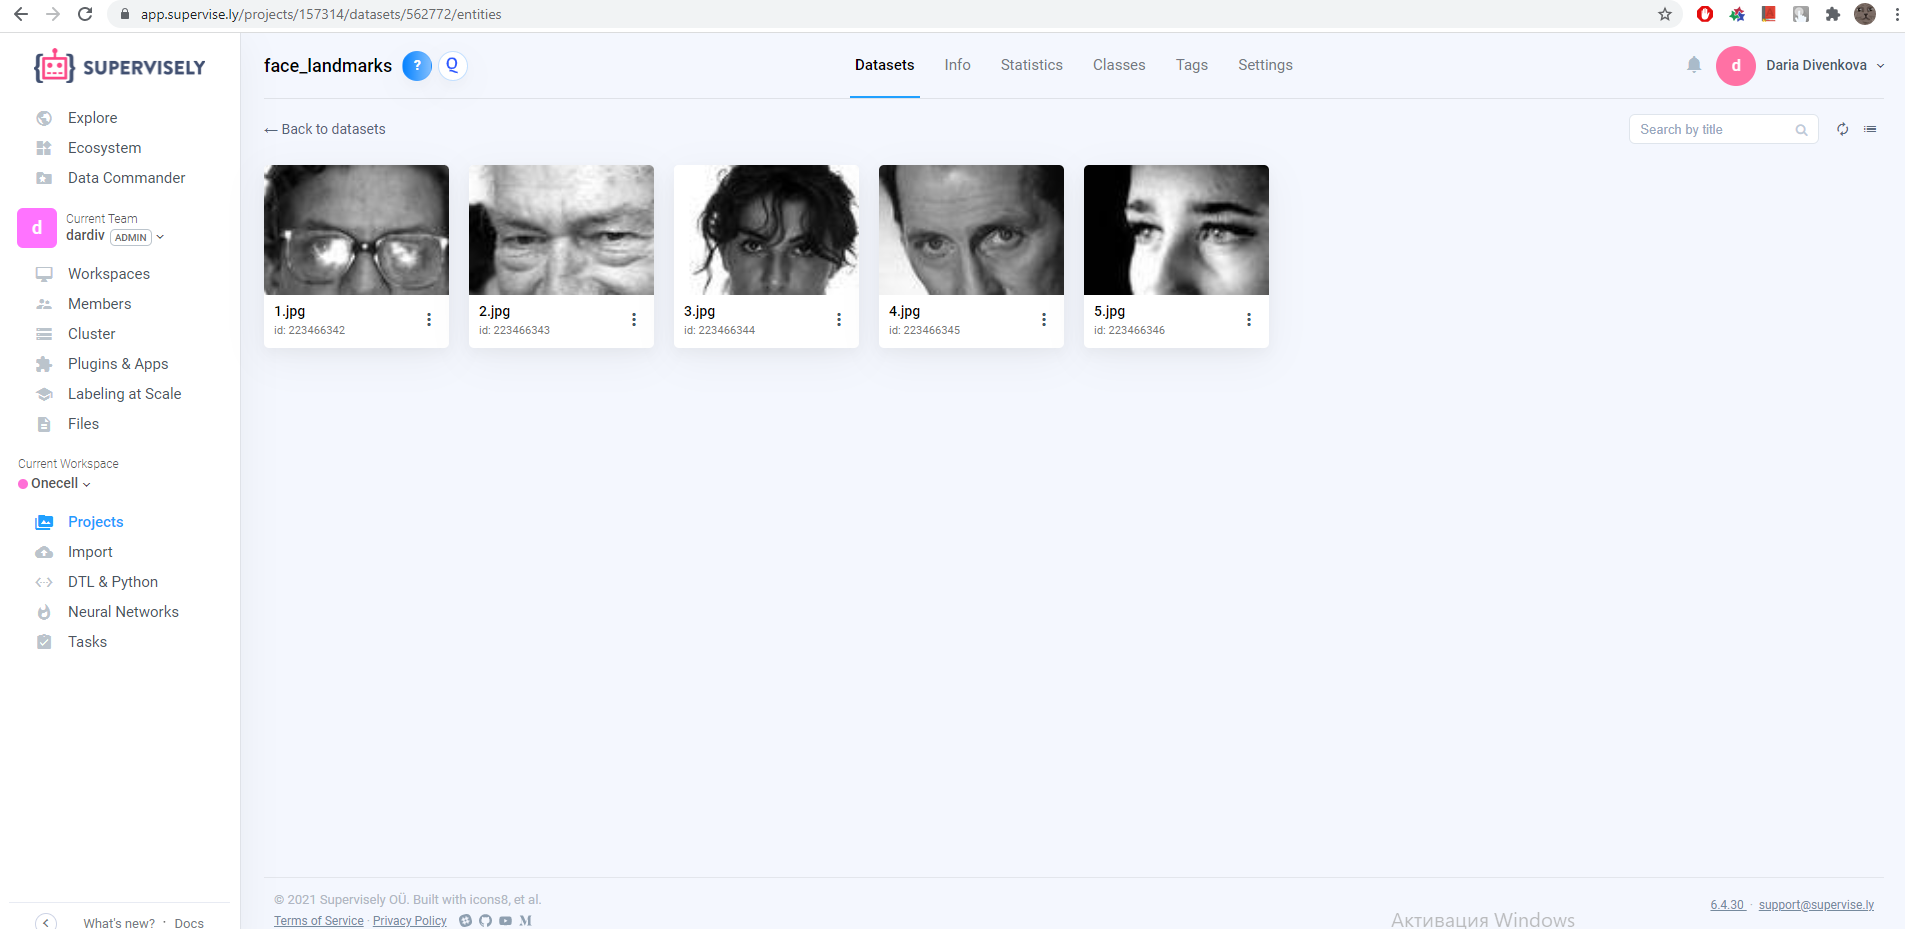

### Время разметки

Среднее время разметки с нуля 15 точек одного изображения - 30 секунд.

Так как для всех изображений с наименьшим качеством детектирования модель не определила разметку вообще, то время коррекции разметки не было измерено.